In [12]:
import cv2
import torch
from PIL import Image
import pandas as pd
import numpy as np
import time


%matplotlib inline

In [13]:
cd Sport-analytics/

[Errno 2] No such file or directory: 'Sport-analytics/'
/Users/thodoris/Documents/GitHub/Sport-analytics


In [14]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /Users/thodoris/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 2021-5-25 torch 1.8.1 CPU



In [15]:
img = cv2.imread('./Images/Highlights Real Madrid vs FC Barcelona (2-1)/frame24.jpg', cv2.IMREAD_COLOR)

--- 0.37 seconds ---


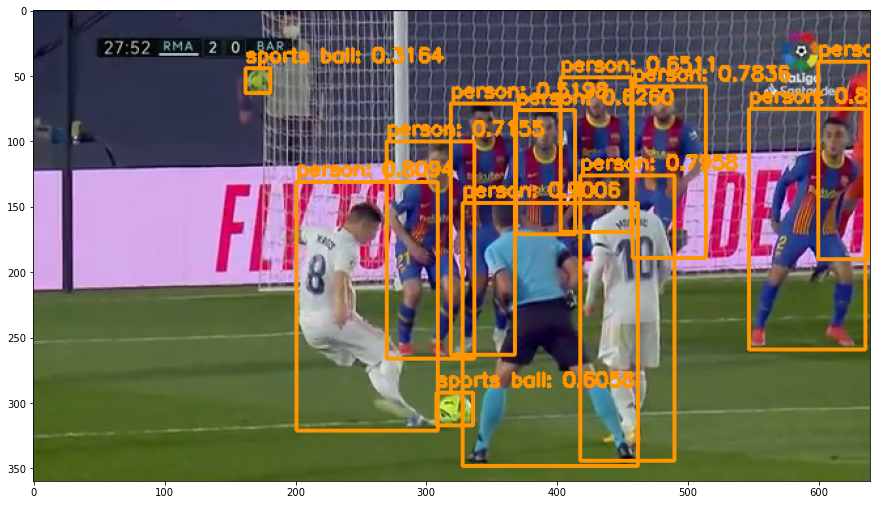

In [16]:
from util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

start_time = time.time()

# inference
results = model(img, size=640)  # includes NMS
boxes = results.pandas().xyxy[0]

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(cv2_img_bb[:,:,::-1])

# cv2.imshow("frame", cv2_img_bb)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

print("--- %.2f seconds ---" % (time.time() - start_time))

https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

The `stepSize` indicates how many pixels we are going to skip in both the (x, y) direction. 

Normally, we would not want to loop over each and every pixel of the image (i.e. `stepSize`=1) as this would be computationally prohibitive if we were applying an image classifier at each window.

Instead, the `stepSize` is determined on a **per-dataset** basis and is tuned to give optimal performance based on your dataset of images. 

In practice, it’s common to use a `stepSize` of 4 to 8 pixels. 

**Remember, the smaller your step size is, the more windows you’ll need to examine.**

In [19]:
from PIL import Image
import math

def sliding_window(img, step_size, window_size):
#     img = Image.open(input_file)
    
    img_width, img_height = img.size
    for y in range(0, img_height, step_size):
        for x in range(0, img_width, step_size):
            box = (x, y, x+window_size[0], y+window_size[1])
            
            if x+window_size[0] <= img_width  and y+window_size[1] <= img_height :
                yield (box, img.crop(box))
                
# *to change* 
# check if objects already detected before adding it to list
def keep_unique_objects_df(boxes_df, epsilon=10):
    ## Remove duplicate objects ##    
    distances = boxes_df.distance.to_list()

    for distance in distances:
        first = True

        for index, row in boxes_df.iterrows():
            if first and abs(row.distance-distance) < epsilon:
                first = False
                continue
            else:
                if abs(row.distance-distance) < epsilon:
                    boxes_df.drop(index, inplace=True)   
    return boxes_df


def split_image_and_predict(img, model, step_size=64, window_size=(256,256)):
    
    img = Image.fromarray(img[:,:,::-1])
    
    boxes_df = pd.DataFrame(columns = ['xmin','ymin','xmax','ymax','confidence','class','name','centerx','centery'])
    
    for i,(box,img) in enumerate(sliding_window(img, step_size, window_size)):
       
        # inference
        results = model(img, size=320)  # includes NMS
        boxes = results.pandas().xyxy[0]
 
        # project to starting image
        boxes.xmin = boxes.xmin+box[0]
        boxes.xmax = boxes.xmax+box[0]

        boxes.ymin = boxes.ymin+box[1]
        boxes.ymax = boxes.ymax+box[1]

        boxes['centerx'] = boxes.xmax - (boxes.xmax-boxes.xmin)/2
        boxes['centery'] = boxes.ymax - (boxes.ymax-boxes.ymin)/2
        boxes['distance'] = np.sqrt(boxes.centerx*boxes.centerx + boxes.centery*boxes.centery)

        boxes_df = boxes_df.append(boxes, ignore_index=True)

    boxes_df = keep_unique_objects_df(boxes_df)

    return boxes_df

--- 2.70 seconds ---


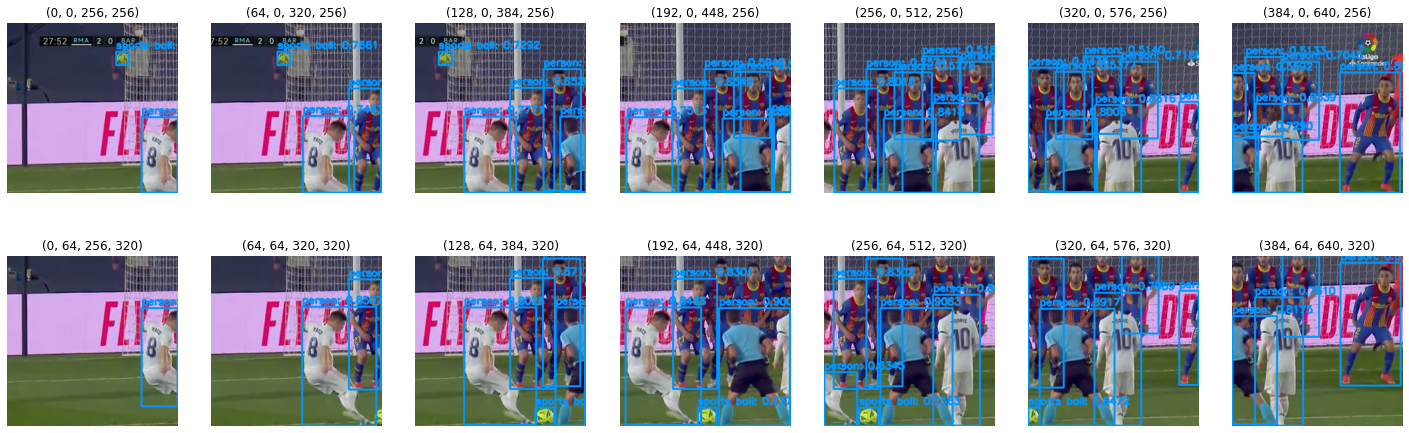

In [21]:
from PIL import Image
import math


fig = plt.figure(figsize=(25, 25))

img_path = './Images/Highlights Real Madrid vs FC Barcelona (2-1)/frame24.jpg'
img = Image.open(img_path)
img_width, img_height = img.size

step_size= 64
window_size = (256,256)

columns = math.ceil(int(img_width / step_size))-3
rows = math.ceil(img_height / step_size)

ax = []

boxes_df = pd.DataFrame(columns = ['xmin','ymin','xmax','ymax','confidence','class','name','centerx','centery'])

start_time = time.time()

for i,(box,img) in enumerate(sliding_window(img, step_size, window_size)):
    ax.append(fig.add_subplot(rows, columns, i+1))
 
    # inference
    results = model(img, size=320)  # includes NMS
    boxes = results.pandas().xyxy[0]
    
  
    # plot bounding boxes
    cv2_img_bb = plot_bb_on_img(img, boxes)
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)
    plt.title(box)
    plt.imshow(cv2_img_bb)
    plt.axis('off')
    
    # project to starting image
    boxes.xmin = boxes.xmin+box[0]
    boxes.xmax = boxes.xmax+box[0]

    boxes.ymin = boxes.ymin+box[1]
    boxes.ymax = boxes.ymax+box[1]

    boxes['centerx'] = boxes.xmax - (boxes.xmax-boxes.xmin)/2
    boxes['centery'] = boxes.ymax - (boxes.ymax-boxes.ymin)/2
    boxes['distance'] = np.sqrt(boxes.centerx*boxes.centerx + boxes.centery*boxes.centery)
    
    boxes_df = boxes_df.append(boxes, ignore_index=True)
    
boxes_df = keep_unique_objects_df(boxes_df)

                
                
print("--- %.2f seconds ---" % (time.time() - start_time))

In [22]:
boxes_df

xmin        ymin        xmax        ymax  confidence class  \
0   201.956528  142.301590  255.967484  255.695160    0.769953     0   
1   163.452621   44.493458  183.204865   64.562180    0.753733    32   
2   191.132965   11.602084  203.641556   21.988388    0.414843    32   
3   270.644989   99.458229  319.640839  255.145584    0.808843     0   
9   320.472855   70.513535  377.013672  253.471878    0.763477     0   
10  345.287384  141.998047  383.803101  255.782516    0.762886     0   
14  345.692047  144.971848  422.767670  255.869827    0.800344     0   
18  419.537796  137.768890  447.883255  255.364899    0.500736     0   
21  419.949127  121.667870  489.913574  256.000000    0.819054     0   
29  546.536591  119.885254  575.996368  255.877487    0.782334     0   
34  545.570190   75.811295  636.542999  256.000000    0.888023     0   
36  384.431584  165.110306  423.451210  255.174957    0.729045     0   
40  606.436523   41.802784  639.855713  195.480804    0.309366     0   
63  256.502933  239.945114  306.270504  320.000000    0.634530     0   

           name     centerx     centery    distance  
0        person  228.962006  198.998375  303.354501  
1   sports ball  173.328743   54.527819  181.703429  
2   sports ball  197.387260   16.795236  198.100506  
3        person  295.142914  177.301907  344.304089  
9        person  348.743263  161.992706  384.530234  
10       person  364.545242  198.890282  415.271692  
14       person  384.229858  200.420837  433.360238  
18       person  433.710526  196.566895  476.175770  
21       person  454.931351  188.833935  492.565517  
29       person  561.266479  187.881371  591.877918  
34       person  591.056595  165.905647  613.899489  
36       person  403.941397  210.142632  455.333480  
40       person  623.146118  118.641794  634.339783  
63       person  281.386718  279.972557  396.942210

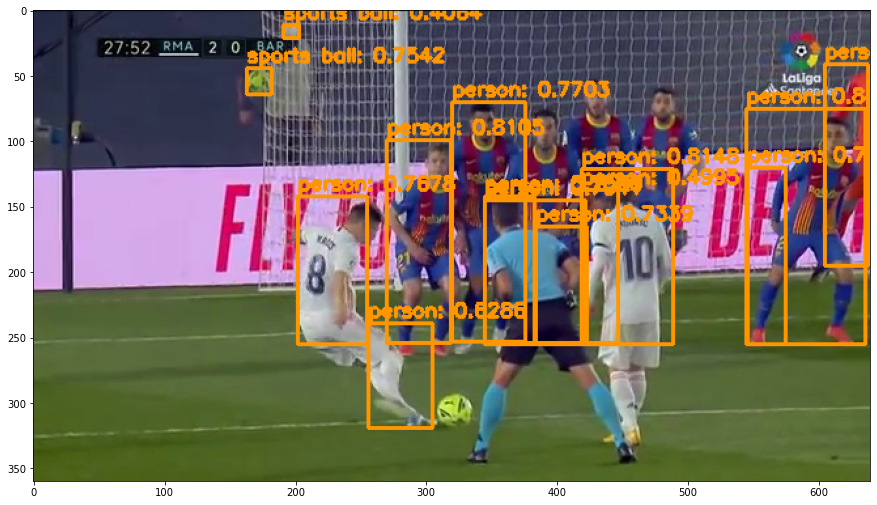

In [23]:
from util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

img = cv2.imread('./Images/Highlights Real Madrid vs FC Barcelona (2-1)/frame24.jpg', cv2.IMREAD_COLOR)

boxes =  split_image_and_predict(img, model)

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(cv2_img_bb[:,:,::-1])

In [24]:
boxes

xmin        ymin        xmax        ymax  confidence class  \
0   202.104507  142.332596  255.973724  255.696747    0.767785     0   
1   163.446625   44.474655  183.256760   64.632538    0.754244    32   
2   191.183807   11.575702  203.634796   21.922466    0.406399    32   
3   270.538986   99.277252  319.625809  255.069534    0.810493     0   
9   320.351852   70.428879  377.009125  253.595978    0.770312     0   
10  345.415558  142.888153  383.827469  254.997955    0.758039     0   
14  345.646240  145.345551  422.929291  255.902786    0.794115     0   
18  419.395905  137.875443  447.886765  255.324951    0.499473     0   
21  419.846649  121.527359  489.890823  255.998489    0.814835     0   
29  546.415863  120.061256  575.995361  255.857574    0.785035     0   
34  545.489624   75.540413  636.651733  256.000000    0.884689     0   
36  384.426585  165.217316  423.593311  255.162354    0.733891     0   
40  605.920334   41.108551  639.861206  195.862061    0.321082     0   
63  256.523360  239.898636  306.473042  320.000000    0.628590     0   

           name     centerx     centery    distance  
0        person  229.039116  199.014671  303.423394  
1   sports ball  173.351692   54.553596  181.733057  
2   sports ball  197.409302   16.749084  198.118561  
3        person  295.082397  177.173393  344.186044  
9        person  348.680489  162.012428  384.481612  
10       person  364.621513  198.943054  415.363921  
14       person  384.287766  200.624168  433.505644  
18       person  433.641335  196.600197  476.126500  
21       person  454.868736  188.762924  492.480465  
29       person  561.205612  187.959415  591.844981  
34       person  591.070679  165.770206  613.876460  
36       person  404.009948  210.189835  455.416079  
40       person  622.890770  118.485306  634.059681  
63       person  281.498201  279.949318  397.004858